# Classifying WebMD Drug Reviews

## Introduction
In this notebook, I build a number of different classifiers that predict ratings from WebMD drug reviews using natural language processing (NLP) methods. I start with the classical ways of representing documents such as bag-of-words (BOW) and term frequency-inverse document frequency (TF-IDF) and progress to newer techniques that pass word embeddings (Word2Vec and GloVe) into neural network architectures including convolutional neural network (CNN), recurrent neural network (RNN), long short-term memory (LSTM) and transfer learning with large language models (LLMs) such as BERT and GPT. The intuition behind all methods other than the LLMs and examples of how to use them in Python come from the book Natural Language Processing in Action [1]. The book is available for free to those with a .edu email address from select institutions that have partnered with O'Reilly Media at https://learning.oreilly.com/library/view/natural-language-processing/9781617294631/.

## Setup

In [1]:
# imports
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import tensorflow as tf
import smart_open
import gensim
from tqdm import tqdm # progress bar

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# set random seeds
np.random.seed(0)
tf.random.set_seed(0)

In [3]:
# # indicate whether dataset has already been spellchecked (True) or whether spellchecking is needed (False)
# spellchecked = False

In [4]:
# download WordNet model for lemmatization
nltk.download('wordnet')
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/co

In [5]:
# load datasets from scraping reviews from drugs on WebMD depression drugs list
corpus_psych = pd.read_csv('/kaggle/input/psychiatric-drug-webmd-reviews/psychiatric_drug_webmd_reviews.csv',
                     encoding_errors='replace', # use replacement character for characters not in UTF-8
                     index_col=0)

corpus_diabetes = pd.read_csv('/kaggle/input/webmd-reviews-for-diabetes-drugs/diabetes_drug_webmd_reviews.csv',
                     encoding_errors='replace', # use replacement character for characters not in UTF-8
                     index_col=0)

corpus_hypertension = pd.read_csv('/kaggle/input/webmd-reviews-for-hypertension-drugs/hypertension_drug_webmd_reviews.csv',
                     encoding_errors='replace', # use replacement character for characters not in UTF-8
                     index_col=0)


# consolidate datasets into a single corpus
corpus = pd.concat([corpus_psych, corpus_diabetes, corpus_hypertension], ignore_index=True).drop_duplicates(ignore_index=True)

# drop NAs
print(f'Before dropping records with NAs for overall rating or review text: {len(corpus)}')
corpus = corpus.dropna(subset=['rating_overall', 'text'], axis=0)
corpus = corpus.reset_index(drop=True)
print(f'After dropping NAs: {len(corpus)}')

corpus.head(5)

Before dropping records with NAs for overall rating or review text: 81666
After dropping NAs: 71046


,drug_name,date,age,gender,time_on_drug,reviewer_type,condition,rating_overall,rating_effectiveness,rating_ease_of_use,rating_satisfaction,text
0,Sertraline Oral,5/12/2024,45-54,Female,1 to less than 2 years,Patient,Posttraumatic Stress Syndrome,5.0,5,5,5,It's almost two years now and it has been so e...
1,Sertraline Oral,4/21/2024,35-44,Female,less than 1 month,Patient,Depression,1.0,1,1,1,Iv been on this 4 weeks and iv never felt so a...
2,Sertraline Oral,4/16/2024,25-34,Female,2 to less than 5 years,Patient,Repeated Episodes of Anxiety,4.3,4,4,5,Been taking sertraline for past 3 years. Had n...
3,Sertraline Oral,4/11/2024,45-54,Male,less than 1 month,Patient,Panic Disorder,1.7,1,3,1,"Of course, take this with a pinch of salt beca..."
4,Sertraline Oral,4/8/2024,13-18,Female,NaN,Patient,Major Depressive Disorder,3.0,2,4,3,used for a while saw no effects.


In [6]:
# for this analysis, disregard the other available info about each review
corpus = corpus[['rating_overall', 'text']]

## Exploratory Data Analysis

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


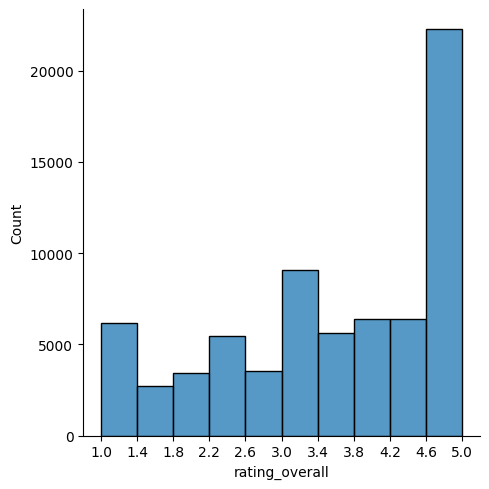

In [7]:
# plot distribution of ratings
bins = 10
bin_width = (5-1)/bins
ax = sns.displot(corpus, x='rating_overall', bins=bins)
plt.xticks(np.arange(1, 5+bin_width, bin_width))

plt.show()

<Axes: xlabel='rating_rounded', ylabel='count'>

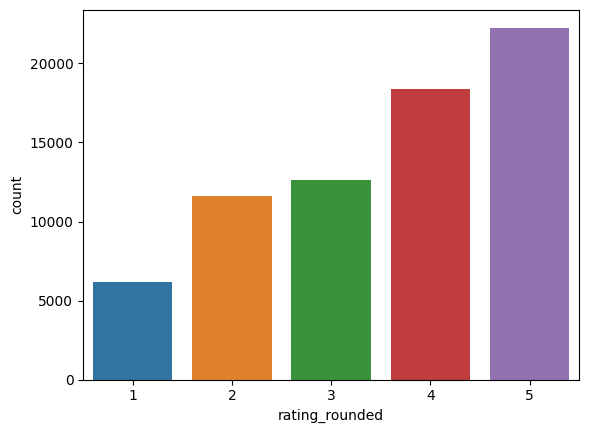

In [8]:
# round ratings and plot distribution
corpus['rating_rounded'] = corpus['rating_overall'].round().astype(int)
sns.countplot(corpus, x='rating_rounded')

## Text Preprocessing
Before performing classification, it is necessary to apply some preprocessing steps to the textual data to reduce noise. Here, I perform spellchecking, tokenization, lemmatization, and removal of punctuation. NLPiA actually recommends leaving in stop words to retain information about phrases that contain stop words, so I do not remove stop words in this analysis.

In [9]:
# !pip install pyspellchecker

In [10]:
# # correct spellings
# # a time consuming process - skip for now
# from spellchecker import SpellChecker
# from tqdm import tqdm

# if not spellchecked:

#     corpus['text_spellchecked'] = corpus['text'].copy()

#     speller = SpellChecker()
#     speller.distance = 2
#     speller.word_frequency.load_words(['Abilify', 'Lexapro', 'SSRI', 'Lamictal', 'Klonopin', 'Latuda', 'escitalopram', 'aripiprazole', 'risperdal'])

#     for i, sentence in enumerate(tqdm(corpus['text'])):
#         words = sentence.split(' ')
#         corpus.loc[i, 'text_spellchecked'] = ' '.join([speller.correction(word) if speller.correction(word) is not None else word for word in words])

#     # print the words unrecognized by the spellchecker

#     from itertools import chain
#     words = np.unique(list(chain(*[sentence.split(' ') for sentence in corpus['text_spellchecked']])))
#     speller.unknown(words)

#     # save and inspect result of spell checking

#     corpus.to_csv('webmd_drug_reviews_spellchecked.csv')
#     corpus.head(10)
    
# # load already spellchecked corpus
# else:
#     corpus = pd.read_csv('/kaggle/input/webmd-drug-reviews-spellchecked/webmd_drug_reviews_spellchecked.csv')

In [11]:
# apply preprocessing steps - tokenization, lowercase, remove punctuation, lemmatization
# Natural Language Processing in Action book recommends leaving in stop words
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

# skip removing stop words
# stopwords = nltk.corpus.stopwords.words('english')

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens_lower = [token.lower() for token in tokens]
    tokens_no_punct = [token for token in tokens_lower if token not in string.punctuation]
    # tokens_no_stopwords = [token for token in tokens_no_punct if token not in stopwords]
    tokens_lemmatized = [lemmatizer.lemmatize(token) for token in tokens_no_punct]
    sentence = ' '.join(tokens_lemmatized)
    return sentence

In [12]:
# corpus['text_preprocessed'] = corpus['text_spellchecked'].apply(preprocess_text)
corpus['text_preprocessed'] = corpus['text'].apply(preprocess_text)

# drop any entries that are now empty
corpus = corpus[corpus['text_preprocessed'] != '']
corpus['text_preprocessed'].head(5)

0    it 's almost two year now and it ha been so ef...
1    iv been on this 4 week and iv never felt so an...
2    been taking sertraline for past 3 year had no ...
3    of course take this with a pinch of salt becau...
4                       used for a while saw no effect
Name: text_preprocessed, dtype: object

In [13]:
# generate sequences (encode tokens using numeric values) that are padded to the same length
# make equal length sequences in order to use as neural network input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

VOCAB_SIZE = 3000
MAX_SEQUENCE_LENGTH = 150

tokenizer = Tokenizer(oov_token='<OOV>', num_words=VOCAB_SIZE)

sentences = corpus['text_preprocessed']

# generate word indexes
tokenizer.fit_on_texts(sentences)

# generate sequences and apply padding
sequences = tokenizer.texts_to_sequences(sentences)
sequences_padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

# instead of a list of documents, make each entry in the list a sublist of tokens in a document
tokens_sentences = [x.split() for x in sentences]

## Helper Functions


In [14]:
# get 1 and 5 star ratings only
# perform after train-test split to have same division of samples when classifying all reviews
def generate_subsets(X, y):
    # subset of 1 and 5 star ratings
    keep = (y == 0) | (y == 4)

    X_subset = X[keep]
    y_subset = y[keep]
    y_subset = np.array([y if y==0 else 1 for y in y_subset])
    
    return X_subset, y_subset

In [15]:
# evaluation metrics
# compute accuracy and balanced accuracy and plot confusion matrix
# balanced accuracy: average of recall obtained for each class
from sklearn.metrics import accuracy_score, balanced_accuracy_score, ConfusionMatrixDisplay, confusion_matrix

def evaluation(y_test, y_pred):
    print(f'accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print(f'balanced accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}')

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    cm = confusion_matrix(y_test, y_pred)
    classes = np.unique(y_test) + 1  # sorted in ascending order
    cm_plot = ConfusionMatrixDisplay(cm, display_labels=classes)
    cm_plot.plot(cmap='Blues', ax=ax)
    im = cm_plot.im_
    im.colorbar.remove()
    plt.colorbar(im, orientation='horizontal', pad=0.2, label='Number of samples')

    plt.title('');

## Classical NLP

### Bag of Words and Naive Bayes

In [16]:
# define y
y = corpus['rating_rounded'] - 1  # get labels 0-4 instead of 1-5

In [17]:
# use only 1 and 5 star ratings to generate BOW because full dataset does not fit in RAM
keep = (y == 0) | (y == 4)

In [18]:
# produce BOW
from collections import Counter

tokens_sentences_keep = np.array(tokens_sentences, dtype=object)[keep]
bags_of_words = [Counter(sentence) for sentence in tokens_sentences_keep]
df_bows = pd.DataFrame.from_records(bags_of_words)
df_bows = df_bows.fillna(0).astype(int)

In [19]:
from sklearn.model_selection import train_test_split

test_fraction = 0.2
X_train, X_test, y_train, y_test = train_test_split(df_bows,
                                                    y[keep],
                                                    test_size=test_fraction,
                                                    shuffle=True,
                                                    random_state=0
                                                    )

accuracy: 0.8790
balanced accuracy: 0.7816


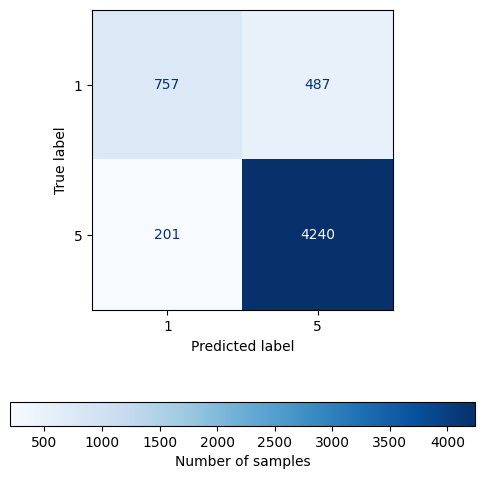

In [20]:
# fit naive Bayes, predict, and evaluate performance
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

evaluation(y_test, y_pred)

### TF-IDF and Latent Semantic Analysis (LSA)

In [21]:
# subset of 1 and 5 star ratings
X_subset, y_subset = generate_subsets(sentences, y)

In [22]:
# produce TF-IDF matrix
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_model = TfidfVectorizer()
tfidf_matrix = tfidf_model.fit_transform(X_subset).toarray()
tfidf_matrix = tfidf_matrix - tfidf_matrix.mean(axis=0) # center data
tfidf_matrix = (tfidf_matrix.T / np.linalg.norm(tfidf_matrix, axis=1)).T  # normalize with L2 norm (vector length)

In [23]:
# perform truncated SVD
from sklearn.decomposition import TruncatedSVD
 
svd = TruncatedSVD(n_components=16, n_iter=100)
svd_topic_vectors = svd.fit_transform(tfidf_matrix)

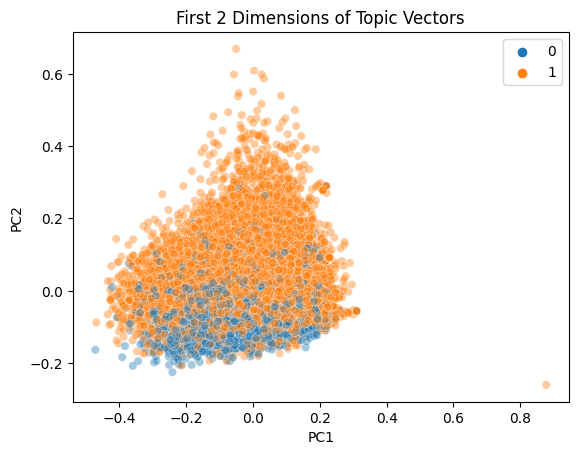

In [24]:
# plot first 2 PCs and color by 1 vs 5 star reviews
x_coord = np.array([doc[0] for doc in svd_topic_vectors])
y_coord = np.array([doc[1] for doc in svd_topic_vectors])

sns.scatterplot(x=x_coord, y=y_coord, hue=y_subset, alpha=0.4) # add 1 to change labels from 0 and 4 to 1 and 5
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('First 2 Dimensions of Topic Vectors');

accuracy: 0.8160
balanced accuracy: 0.6343


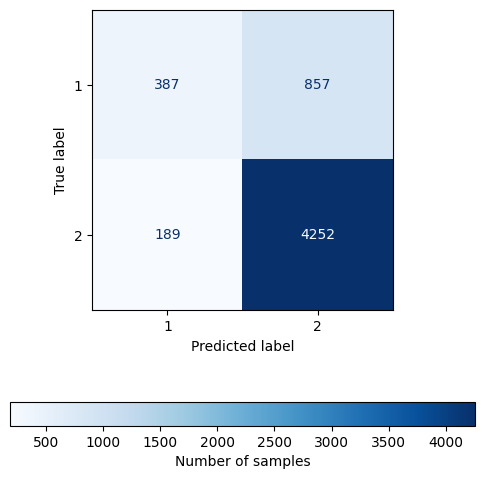

In [25]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X_train, X_test, y_train, y_test = train_test_split(svd_topic_vectors, y_subset, test_size=0.2, random_state=0)
model = LinearDiscriminantAnalysis(n_components=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

evaluation(y_test, y_pred)

## Deep Learning with Word Embeddings

### Convolutional Neural Network (CNN)
[2] contains a tutorial on how to create an embedding layer.

In [26]:
EMBEDDING_DIM = 300

w2v_file = '/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin'
w2v_model = gensim.models.KeyedVectors.load_word2vec_format(w2v_file, binary=True)

In [27]:
# https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
word_index = tokenizer.word_index
word_list = sorted(word_index.items(), key=lambda x:x[1])
word_list = [x[0] for x in word_list]

embedding_values = [w2v_model[word] if word in w2v_model else np.zeros(EMBEDDING_DIM) for word in word_list]
embedding_matrix = np.vstack([np.zeros([1, EMBEDDING_DIM]),
                             np.array(embedding_values)])

In [28]:
from tensorflow.keras.layers import Embedding

embedding_layer_w2v = Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [29]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras import Model

# CNN using Word2Vec embeddings - 1 and 5 star ratings only
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer_w2v(sequence_input)
x = Conv1D(128, 3, activation='relu')(embedded_sequences)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = GlobalMaxPooling1D()(x)
x = Dropout(0.1)(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
preds = Dense(2, activation='softmax')(x)

model = Model(sequence_input, preds)
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [30]:
# perform split, and then take 1 and 5 star ratings in order to have same division of samples when classifying all reviews
test_fraction = 0.2
X_train, X_test, y_train, y_test = train_test_split(sequences_padded,
                                                    y,
                                                    test_size=test_fraction,
                                                    shuffle=True,
                                                    random_state=0
                                                    )

# subset of 1 and 5 star ratings
X_train_subset, y_train_subset = generate_subsets(X_train, y_train)
X_test_subset, y_test_subset = generate_subsets(X_test, y_test)

In [31]:
from sklearn.utils import class_weight

classes_subset = [0, 1] # labels were transformed in generate_subsets function
class_weights_subset = class_weight.compute_class_weight('balanced', classes=classes_subset, y=y_train_subset)
class_weights_subset = dict(enumerate(class_weights_subset))

In [32]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                       mode='min',
                                                       verbose=1,
                                                       patience=3)

In [33]:
model.fit(X_train_subset,
          y_train_subset,
          epochs=20,
          batch_size=32,
          validation_split=0.1,
          class_weight=class_weights_subset,
          callbacks=early_stop_callback)

y_pred = model.predict(X_test_subset)
y_pred_label = [np.argmax(y) for y in y_pred]

Epoch 1/20
638/638 [==============================] - 7s 5ms/step - loss: 0.4647 - accuracy: 0.7763 - val_loss: 0.3560 - val_accuracy: 0.8413
Epoch 2/20
638/638 [==============================] - 3s 4ms/step - loss: 0.3401 - accuracy: 0.8448 - val_loss: 0.3282 - val_accuracy: 0.8514
Epoch 3/20
638/638 [==============================] - 3s 4ms/step - loss: 0.2811 - accuracy: 0.8750 - val_loss: 0.2874 - val_accuracy: 0.8717
Epoch 4/20
638/638 [==============================] - 3s 5ms/step - loss: 0.2362 - accuracy: 0.8963 - val_loss: 0.2980 - val_accuracy: 0.8713
Epoch 5/20
638/638 [==============================] - 3s 4ms/step - loss: 0.2037 - accuracy: 0.9097 - val_loss: 0.2677 - val_accuracy: 0.8814
Epoch 6/20
638/638 [==============================] - 3s 4ms/step - loss: 0.1806 - accuracy: 0.9211 - val_loss: 0.2369 - val_accuracy: 0.9008
Epoch 7/20
638/638 [==============================] - 3s 4ms/step - loss: 0.1589 - accuracy: 0.9300 - val_loss: 0.3154 - val_accuracy: 0.8713
Epoch 

accuracy: 0.8831
balanced accuracy: 0.8672


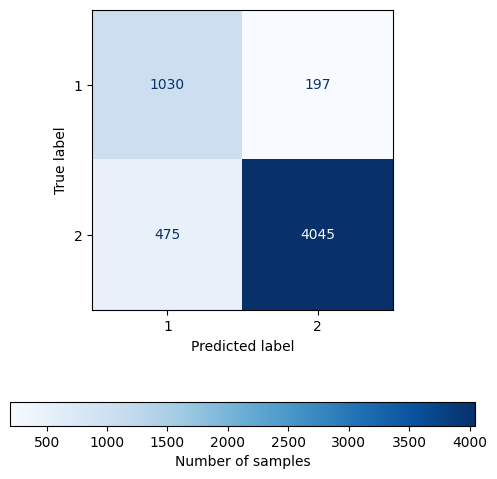

In [34]:
# CNN using Word2Vec embeddings
evaluation(y_test_subset, y_pred_label)

In [35]:
glove_file = '/kaggle/input/glove-embeddings/glove.6B.300d.txt'
glove_model = gensim.models.KeyedVectors.load_word2vec_format(
                glove_file,
                binary=False,
                no_header=True)

In [36]:
embedding_values = [glove_model[word] if word in glove_model else np.zeros(EMBEDDING_DIM) for word in word_list]
embedding_matrix = np.vstack([np.zeros([1, EMBEDDING_DIM]),
                             np.array(embedding_values)])
                             
embedding_layer_glove = Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [37]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras import Model

# CNN using GloVe embeddings - 1 and 5 star ratings only
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer_glove(sequence_input)
x = Conv1D(128, 3, activation='relu')(embedded_sequences)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = GlobalMaxPooling1D()(x)
x = Dropout(0.1)(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
preds = Dense(2, activation='softmax')(x)

model = Model(sequence_input, preds)
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [38]:
model.fit(X_train_subset,
          y_train_subset,
          epochs=20,
          batch_size=32,
          validation_split=0.1,
          class_weight=class_weights_subset,
          callbacks=early_stop_callback)

y_pred = model.predict(X_test_subset)
y_pred_label = [np.argmax(y) for y in y_pred]

Epoch 1/20
638/638 [==============================] - 5s 5ms/step - loss: 0.5135 - accuracy: 0.7396 - val_loss: 0.3567 - val_accuracy: 0.8439
Epoch 2/20
638/638 [==============================] - 3s 4ms/step - loss: 0.3839 - accuracy: 0.8195 - val_loss: 0.3161 - val_accuracy: 0.8717
Epoch 3/20
638/638 [==============================] - 3s 4ms/step - loss: 0.3202 - accuracy: 0.8550 - val_loss: 0.3399 - val_accuracy: 0.8439
Epoch 4/20
638/638 [==============================] - 3s 4ms/step - loss: 0.2849 - accuracy: 0.8741 - val_loss: 0.3075 - val_accuracy: 0.8598
Epoch 5/20
638/638 [==============================] - 3s 4ms/step - loss: 0.2455 - accuracy: 0.8915 - val_loss: 0.2426 - val_accuracy: 0.8977
Epoch 6/20
638/638 [==============================] - 3s 4ms/step - loss: 0.2251 - accuracy: 0.9006 - val_loss: 0.2661 - val_accuracy: 0.8836
Epoch 7/20
638/638 [==============================] - 3s 4ms/step - loss: 0.2003 - accuracy: 0.9116 - val_loss: 0.2397 - val_accuracy: 0.8946
Epoch 

accuracy: 0.8954
balanced accuracy: 0.8510


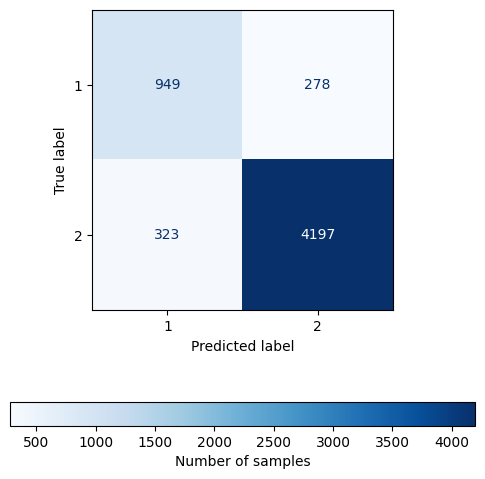

In [39]:
# CNN using GloVe embeddings
evaluation(y_test_subset, y_pred_label)

### Bidirectional Recurrent Neural Network (RNN)

In [40]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Bidirectional

# bidirectional RNN using Word2Vec embeddings - 1 and 5 star ratings only
model = Sequential()
model.add(Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'))
model.add(embedding_layer_w2v)
model.add(Bidirectional(SimpleRNN(
            128,
            return_sequences=False,
            input_shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM))))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))

model.compile('rmsprop', 'sparse_categorical_crossentropy',  metrics=['accuracy'])

with tf.device('/gpu:0'):
    model.fit(X_train_subset,
              y_train_subset,
              epochs=20,
              batch_size=32,
              validation_split=0.1,
              class_weight=class_weights_subset,
              callbacks=early_stop_callback)
    
y_pred = model.predict(X_test_subset)
y_pred_label = [np.argmax(y) for y in y_pred]

Epoch 1/20
638/638 [==============================] - 121s 186ms/step - loss: 0.6620 - accuracy: 0.6322 - val_loss: 0.4146 - val_accuracy: 0.8170
Epoch 2/20
638/638 [==============================] - 118s 185ms/step - loss: 0.5632 - accuracy: 0.7242 - val_loss: 0.4446 - val_accuracy: 0.7901
Epoch 3/20
638/638 [==============================] - 118s 185ms/step - loss: 0.5322 - accuracy: 0.7414 - val_loss: 0.7907 - val_accuracy: 0.4506
Epoch 4/20
638/638 [==============================] - 116s 182ms/step - loss: 0.5430 - accuracy: 0.7344 - val_loss: 0.5714 - val_accuracy: 0.7116
Epoch 4: early stopping
180/180 [==============================] - 4s 23ms/step


accuracy: 0.7052
balanced accuracy: 0.7230


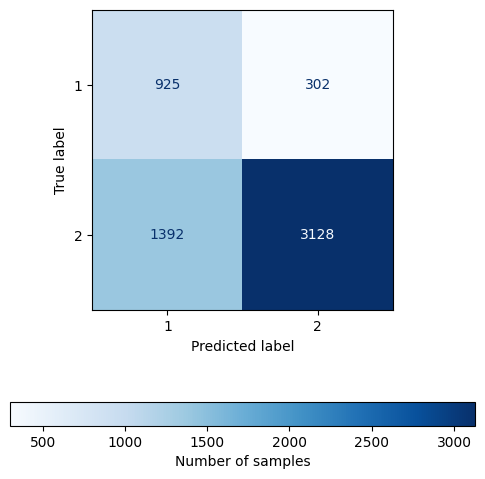

In [41]:
# bidirectional RNN using Word2Vec embeddings
evaluation(y_test_subset, y_pred_label)

In [42]:
# bidirectional RNN using GloVe embeddings - 1 and 5 star ratings only
model = Sequential()
model.add(Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'))
model.add(embedding_layer_glove)
model.add(Bidirectional(SimpleRNN(
            128,
            return_sequences=False,
            input_shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM))))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))

model.compile('rmsprop', 'sparse_categorical_crossentropy',  metrics=['accuracy'])

with tf.device('/gpu:0'):
    model.fit(X_train_subset,
              y_train_subset,
              epochs=20,
              batch_size=32,
              validation_split=0.1,
              class_weight=class_weights_subset,
              callbacks=early_stop_callback)
    
y_pred = model.predict(X_test_subset)
y_pred_label = [np.argmax(y) for y in y_pred]

Epoch 1/20
638/638 [==============================] - 124s 191ms/step - loss: 0.6764 - accuracy: 0.6318 - val_loss: 0.5087 - val_accuracy: 0.7460
Epoch 2/20
638/638 [==============================] - 121s 190ms/step - loss: 0.5860 - accuracy: 0.6974 - val_loss: 0.5703 - val_accuracy: 0.7231
Epoch 3/20
638/638 [==============================] - 121s 189ms/step - loss: 0.5563 - accuracy: 0.7192 - val_loss: 0.5105 - val_accuracy: 0.7593
Epoch 4/20
638/638 [==============================] - 119s 187ms/step - loss: 0.5363 - accuracy: 0.7343 - val_loss: 0.5605 - val_accuracy: 0.7183
Epoch 4: early stopping
180/180 [==============================] - 4s 22ms/step


accuracy: 0.7204
balanced accuracy: 0.7513


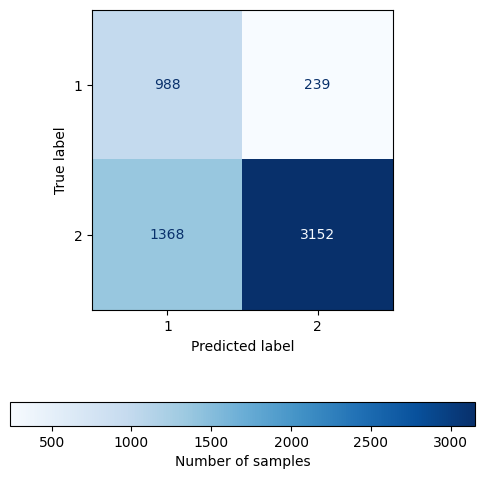

In [43]:
# bidirectional RNN using GloVe embeddings
evaluation(y_test_subset, y_pred_label)

### Long Short-Term Memory (LSTM) Network

In [44]:
from tensorflow.keras.layers import LSTM

# bidirectional LSTM using Word2Vec embeddings - 1 and 5 star ratings only
model = Sequential()
model.add(Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'))
model.add(embedding_layer_w2v)
model.add(Bidirectional(LSTM(
            128,
            return_sequences=False,
            input_shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM))))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))

model.compile('rmsprop', 'sparse_categorical_crossentropy',  metrics=['accuracy'])

with tf.device('/gpu:0'):
    model.fit(X_train_subset,
              y_train_subset,
              epochs=20,
              batch_size=32,
              validation_split=0.1,
              class_weight=class_weights_subset,
              callbacks=early_stop_callback)
    
y_pred = model.predict(X_test_subset)
y_pred_label = [np.argmax(y) for y in y_pred]

Epoch 1/20
638/638 [==============================] - 12s 14ms/step - loss: 0.5195 - accuracy: 0.7516 - val_loss: 0.3694 - val_accuracy: 0.8492
Epoch 2/20
638/638 [==============================] - 8s 13ms/step - loss: 0.4362 - accuracy: 0.8066 - val_loss: 0.4283 - val_accuracy: 0.8047
Epoch 3/20
638/638 [==============================] - 8s 13ms/step - loss: 0.3992 - accuracy: 0.8233 - val_loss: 0.5025 - val_accuracy: 0.7623
Epoch 4/20
638/638 [==============================] - 8s 13ms/step - loss: 0.3663 - accuracy: 0.8386 - val_loss: 0.4876 - val_accuracy: 0.7795
Epoch 4: early stopping
180/180 [==============================] - 2s 5ms/step


accuracy: 0.7825
balanced accuracy: 0.8311


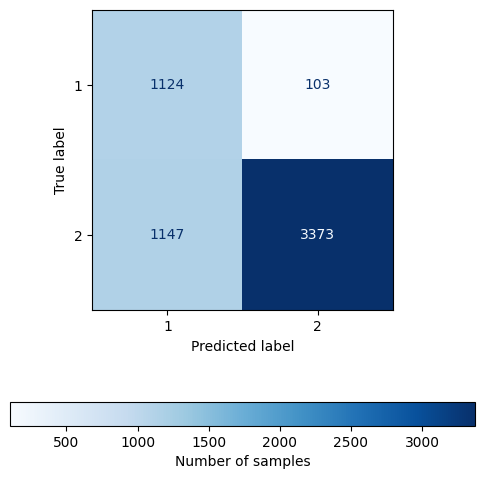

In [45]:
# LSTM using Word2Vec embeddings
evaluation(y_test_subset, y_pred_label)

In [46]:
# bidirectional LSTM using GloVe embeddings - 1 and 5 star ratings only
model = Sequential()
model.add(Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'))
model.add(embedding_layer_glove)
model.add(Bidirectional(LSTM(
            128,
            return_sequences=False,
            input_shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM))))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))

model.compile('rmsprop', 'sparse_categorical_crossentropy',  metrics=['accuracy'])

with tf.device('/gpu:0'):
    model.fit(X_train_subset,
              y_train_subset,
              epochs=20,
              batch_size=32,
              validation_split=0.1,
              class_weight=class_weights_subset,
              callbacks=early_stop_callback)
    
y_pred = model.predict(X_test_subset)
y_pred_label = [np.argmax(y) for y in y_pred]

Epoch 1/20
638/638 [==============================] - 13s 14ms/step - loss: 0.5397 - accuracy: 0.7339 - val_loss: 0.3792 - val_accuracy: 0.8408
Epoch 2/20
638/638 [==============================] - 8s 13ms/step - loss: 0.4133 - accuracy: 0.8180 - val_loss: 0.4143 - val_accuracy: 0.8122
Epoch 3/20
638/638 [==============================] - 8s 13ms/step - loss: 0.3456 - accuracy: 0.8478 - val_loss: 0.4467 - val_accuracy: 0.7928
Epoch 4/20
638/638 [==============================] - 8s 13ms/step - loss: 0.3026 - accuracy: 0.8707 - val_loss: 0.3661 - val_accuracy: 0.8382
Epoch 5/20
638/638 [==============================] - 8s 13ms/step - loss: 0.2693 - accuracy: 0.8865 - val_loss: 0.2502 - val_accuracy: 0.8990
Epoch 6/20
638/638 [==============================] - 8s 13ms/step - loss: 0.2380 - accuracy: 0.9003 - val_loss: 0.2526 - val_accuracy: 0.9012
Epoch 7/20
638/638 [==============================] - 8s 13ms/step - loss: 0.2088 - accuracy: 0.9117 - val_loss: 0.3133 - val_accuracy: 0.867

accuracy: 0.8704
balanced accuracy: 0.8597


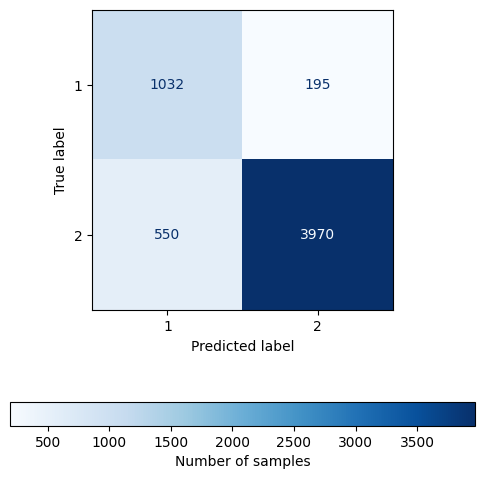

In [47]:
# LSTM using GloVe embeddings
evaluation(y_test_subset, y_pred_label)

In [48]:
# LSTM using Word2Vec embeddings - 1 through 5 star ratings
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer_w2v(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = GlobalMaxPooling1D()(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
preds = Dense(5, activation='softmax')(x)

model = Model(sequence_input, preds)
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [49]:
classes = [0, 1, 2, 3, 4]
class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = dict(enumerate(class_weights))

In [50]:
model.fit(X_train,
          y_train,
          epochs=20,
          batch_size=32,
          validation_split=0.1,
          class_weight=class_weights,
          callbacks=early_stop_callback)

y_pred = model.predict(X_test)
y_pred_label = [np.argmax(y) for y in y_pred]

Epoch 1/20
1599/1599 [==============================] - 12s 6ms/step - loss: 1.4791 - accuracy: 0.3165 - val_loss: 1.3240 - val_accuracy: 0.4167
Epoch 2/20
1599/1599 [==============================] - 8s 5ms/step - loss: 1.3557 - accuracy: 0.3937 - val_loss: 1.2756 - val_accuracy: 0.4269
Epoch 3/20
1599/1599 [==============================] - 9s 5ms/step - loss: 1.2990 - accuracy: 0.4232 - val_loss: 1.2710 - val_accuracy: 0.4337
Epoch 4/20
1599/1599 [==============================] - 9s 5ms/step - loss: 1.2640 - accuracy: 0.4383 - val_loss: 1.2425 - val_accuracy: 0.4258
Epoch 5/20
1599/1599 [==============================] - 8s 5ms/step - loss: 1.2265 - accuracy: 0.4501 - val_loss: 1.2191 - val_accuracy: 0.4408
Epoch 6/20
1599/1599 [==============================] - 8s 5ms/step - loss: 1.1891 - accuracy: 0.4635 - val_loss: 1.2323 - val_accuracy: 0.4480
Epoch 7/20
1599/1599 [==============================] - 9s 5ms/step - loss: 1.1587 - accuracy: 0.4780 - val_loss: 1.2433 - val_accuracy

accuracy: 0.4407
balanced accuracy: 0.4161


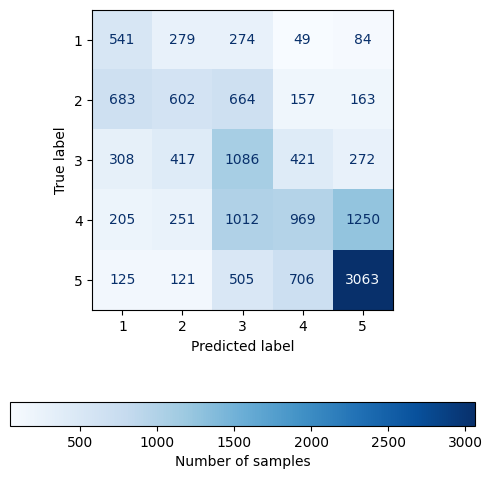

In [51]:
# LSTM using Word2Vec embeddings
evaluation(y_test, y_pred_label)

In [52]:
# LSTM using GloVe embeddings - 1 through 5 star ratings
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer_glove(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = GlobalMaxPooling1D()(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
preds = Dense(5, activation='softmax')(x)

model = Model(sequence_input, preds)
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.fit(X_train,
          y_train,
          epochs=100,
          batch_size=64,
          validation_split=0.1,
          class_weight=class_weights,
          callbacks=early_stop_callback)

y_pred = model.predict(X_test)
y_pred_label = [np.argmax(y) for y in y_pred]

Epoch 1/100
800/800 [==============================] - 8s 7ms/step - loss: 1.5062 - accuracy: 0.3070 - val_loss: 1.4056 - val_accuracy: 0.3660
Epoch 2/100
800/800 [==============================] - 5s 6ms/step - loss: 1.3904 - accuracy: 0.3726 - val_loss: 1.3410 - val_accuracy: 0.3982
Epoch 3/100
800/800 [==============================] - 5s 6ms/step - loss: 1.3326 - accuracy: 0.4067 - val_loss: 1.2749 - val_accuracy: 0.4158
Epoch 4/100
800/800 [==============================] - 5s 6ms/step - loss: 1.2980 - accuracy: 0.4210 - val_loss: 1.3135 - val_accuracy: 0.4065
Epoch 5/100
800/800 [==============================] - 5s 7ms/step - loss: 1.2591 - accuracy: 0.4379 - val_loss: 1.2594 - val_accuracy: 0.4413
Epoch 6/100
800/800 [==============================] - 5s 6ms/step - loss: 1.2318 - accuracy: 0.4497 - val_loss: 1.2555 - val_accuracy: 0.4385
Epoch 7/100
800/800 [==============================] - 5s 6ms/step - loss: 1.1964 - accuracy: 0.4650 - val_loss: 1.2484 - val_accuracy: 0.4436

accuracy: 0.4292
balanced accuracy: 0.4099


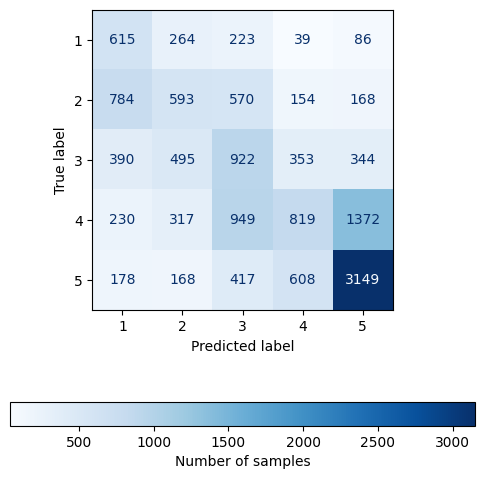

In [53]:
# LSTM using GloVe embeddings
evaluation(y_test, y_pred_label)

## Large Language Models (LLMs)
Fine tuning refers to the process of updating the parameters of an LLM to perform a specific task by feeding it additional data. Here I use DistilBERT, a smaller version of the popular BERT model, and train it with the internal layers frozen (i.e. adding a dense layer for classification only) and again with updating the internal layers during training. [2] contains a tutorial on how to fine tune LLMs loaded from Hugging Face for classification tasks.

### DistilBERT

In [54]:
test_fraction = 0.2
X_train, X_test, y_train, y_test = train_test_split(corpus['text'].values,
                                                    y,
                                                    test_size=test_fraction,
                                                    shuffle=True,
                                                    random_state=0
                                                    )

X_train, X_val, y_train, y_val = train_test_split(corpus['text'].values,
                                                    y,
                                                    test_size=test_fraction/(1-test_fraction),
                                                    shuffle=True,
                                                    random_state=0
                                                    )

X_train_subset, y_train_subset = generate_subsets(X_train, y_train)
X_val_subset, y_val_subset = generate_subsets(X_val, y_val)
X_test_subset, y_test_subset = generate_subsets(X_test, y_test)

In [55]:
# Define the maximum number of words to tokenize (DistilBERT can tokenize up to 512)
MAX_LENGTH = 128

# Define function to encode text data in batches
def batch_encode(tokenizer, texts, batch_size=128, max_length=MAX_LENGTH):
    input_ids = []
    attention_mask = []
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer.batch_encode_plus(batch,
                                             max_length=max_length,
                                             padding='longest', # implements dynamic padding
                                             truncation=True,
                                             return_attention_mask=True,
                                             return_token_type_ids=False
                                             )
        input_ids.extend(inputs['input_ids'])
        attention_mask.extend(inputs['attention_mask'])
    
    
    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_mask)

In [56]:
from transformers import DistilBertTokenizerFast, TFDistilBertModel, DistilBertConfig

tokenizer_bert = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

DROPOUT = 0.2
ATT_DROPOUT = 0.2
 
config = DistilBertConfig(dropout=DROPOUT, 
                          attention_dropout=ATT_DROPOUT, 
                          output_hidden_states=True)
                          
distilBERT = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)

# use pre-trained weights
for layer in distilBERT.layers:
    layer.trainable = False

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [57]:
X_train_ids, X_train_attention = batch_encode(tokenizer_bert, X_train_subset.tolist())
X_valid_ids, X_valid_attention = batch_encode(tokenizer_bert, X_val_subset.tolist())
X_test_ids, X_test_attention = batch_encode(tokenizer_bert, X_test_subset.tolist())

In [58]:
MAX_LENGTH = 128
LAYER_DROPOUT = 0.3
LEARNING_RATE = 5e-4
RANDOM_STATE = 0

def build_model(transformer, max_length=MAX_LENGTH):
    weight_initializer = tf.keras.initializers.GlorotNormal(seed=0) 
    input_ids_layer = tf.keras.layers.Input(shape=(max_length,), 
                                            name='input_ids', 
                                            dtype='int32')
    input_attention_layer = tf.keras.layers.Input(shape=(max_length,), 
                                                  name='input_attention', 
                                                  dtype='int32')
    
    last_hidden_state = transformer([input_ids_layer, input_attention_layer])[0]
    cls_token = last_hidden_state[:, 0, :]

    output = tf.keras.layers.Dense(2, 
                                   activation='softmax',
                                   kernel_initializer=weight_initializer,  
                                   kernel_constraint=None,
                                   bias_initializer='zeros'
                                   )(cls_token)
    
    model = tf.keras.Model([input_ids_layer, input_attention_layer], output)
    
    model.compile(tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [59]:
EPOCHS = 30
BATCH_SIZE = 128
NUM_STEPS = len(X_train_subset) // BATCH_SIZE

model = build_model(distilBERT, MAX_LENGTH)
model.fit(
    x = [X_train_ids, X_train_attention],
    y = np.array(y_train_subset),
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    steps_per_epoch = NUM_STEPS,
    validation_data = ([X_valid_ids, X_valid_attention], np.array(y_val_subset)),
    verbose=2,
    callbacks=early_stop_callback
)

y_pred = model.predict([X_test_ids, X_test_attention])
y_pred_label = [np.argmax(y) for y in y_pred]

Epoch 1/30
166/166 - 129s - loss: 0.4439 - accuracy: 0.8013 - val_loss: 0.3562 - val_accuracy: 0.8304 - 129s/epoch - 777ms/step
Epoch 2/30
166/166 - 119s - loss: 0.3557 - accuracy: 0.8453 - val_loss: 0.3203 - val_accuracy: 0.8647 - 119s/epoch - 719ms/step
Epoch 3/30
166/166 - 119s - loss: 0.3383 - accuracy: 0.8542 - val_loss: 0.3061 - val_accuracy: 0.8678 - 119s/epoch - 719ms/step
Epoch 4/30
166/166 - 119s - loss: 0.3268 - accuracy: 0.8588 - val_loss: 0.3009 - val_accuracy: 0.8710 - 119s/epoch - 720ms/step
Epoch 5/30
166/166 - 119s - loss: 0.3226 - accuracy: 0.8612 - val_loss: 0.2948 - val_accuracy: 0.8738 - 119s/epoch - 719ms/step
Epoch 6/30
166/166 - 119s - loss: 0.3185 - accuracy: 0.8645 - val_loss: 0.2927 - val_accuracy: 0.8747 - 119s/epoch - 717ms/step
Epoch 7/30
166/166 - 119s - loss: 0.3145 - accuracy: 0.8660 - val_loss: 0.2890 - val_accuracy: 0.8766 - 119s/epoch - 720ms/step
Epoch 8/30
166/166 - 120s - loss: 0.3147 - accuracy: 0.8647 - val_loss: 0.2886 - val_accuracy: 0.8757 - 

accuracy: 0.8799
balanced accuracy: 0.7678


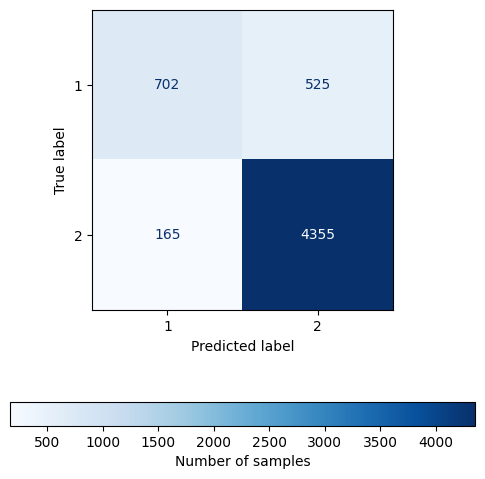

In [60]:
evaluation(y_test_subset, y_pred_label)

In [61]:
# unfreeze layers to train hidden layers as well
for layer in distilBERT.layers:
    layer.trainable = True

In [62]:
EPOCHS = 30
BATCH_SIZE = 64
NUM_STEPS = len(X_train_subset) // BATCH_SIZE

model = build_model(distilBERT, MAX_LENGTH)
model.fit(
    x = [X_train_ids, X_train_attention],
    y = np.array(y_train_subset),
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    steps_per_epoch = NUM_STEPS,
    validation_data = ([X_valid_ids, X_valid_attention], np.array(y_val_subset)),
    verbose=2,
    callbacks=early_stop_callback
)

y_pred = model.predict([X_test_ids, X_test_attention])
y_pred_label = [np.argmax(y) for y in y_pred]

Epoch 1/30
332/332 - 294s - loss: 0.5346 - accuracy: 0.7800 - val_loss: 0.5343 - val_accuracy: 0.7865 - 294s/epoch - 886ms/step
Epoch 2/30
332/332 - 270s - loss: 0.5281 - accuracy: 0.7819 - val_loss: 0.5194 - val_accuracy: 0.7865 - 270s/epoch - 813ms/step
Epoch 3/30
332/332 - 270s - loss: 0.5278 - accuracy: 0.7822 - val_loss: 0.5188 - val_accuracy: 0.7865 - 270s/epoch - 812ms/step
Epoch 4/30
332/332 - 269s - loss: 0.5259 - accuracy: 0.7824 - val_loss: 0.5198 - val_accuracy: 0.7865 - 269s/epoch - 812ms/step
Epoch 5/30
332/332 - 270s - loss: 0.5266 - accuracy: 0.7823 - val_loss: 0.5233 - val_accuracy: 0.7865 - 270s/epoch - 813ms/step
Epoch 6/30
332/332 - 270s - loss: 0.5266 - accuracy: 0.7819 - val_loss: 0.5192 - val_accuracy: 0.7865 - 270s/epoch - 812ms/step
Epoch 6: early stopping
180/180 [==============================] - 25s 129ms/step


[1] Lane, H., Howard, C., Hannes, M. H. (2019). <em>Natural Language Processing in Action.</em> Manning Publications. \
[2] https://towardsdatascience.com/hugging-face-transformers-fine-tuning-distilbert-for-binary-classification-tasks-490f1d192379